In [1]:
import os
import numpy as np
import torch
import pandas as pd
import whisper
import torchaudio
from tqdm.notebook import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
class LibriSpeech(torch.utils.data.Dataset):
    """
    A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    """
    def __init__(self, split="test-clean", device=DEVICE):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("../ASR/"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, _, _, _ = self.dataset[item]
        assert sample_rate == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        
        return (mel, text)

In [11]:
dataset = LibriSpeech("dev-other")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

In [16]:
def test(model = "base.en"):
    model = whisper.load_model(model)
    print(
        f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
        f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
    )
    options = whisper.DecodingOptions(language="en", without_timestamps=True)
    hypotheses = []
    references = []
    for mels, texts in tqdm(loader):
        results = model.decode(mels, options)
        hypotheses.extend([result.text for result in results])
        references.extend(texts)
    from whisper.normalizers import EnglishTextNormalizer

    data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))

    normalizer = EnglishTextNormalizer()
    data["hypothesis_clean"] = [normalizer(text) for text in data["hypothesis"]]
    data["reference_clean"] = [normalizer(text) for text in data["reference"]]
    return data

In [17]:
import jiwer
data = test("base.en")
wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))
print(f"WER: {wer * 100:.2f} %")

Model is English-only and has 71,825,408 parameters.


  0%|          | 0/179 [00:00<?, ?it/s]

WER: 10.02 %


In [19]:
import jiwer
data_tiny = test("tiny.en")
wer = jiwer.wer(list(data_tiny["reference_clean"]), list(data_tiny["hypothesis_clean"]))
print(f"WER: {wer * 100:.2f} %")

WER: 13.52 %


In [20]:
import jiwer
data_small = test("small.en")
wer = jiwer.wer(list(data_small["reference_clean"]), list(data_small["hypothesis_clean"]))
print(f"WER: {wer * 100:.2f} %")

100%|███████████████████████████████████████| 461M/461M [01:24<00:00, 5.74MiB/s]


Model is English-only and has 240,582,144 parameters.


  0%|          | 0/179 [00:00<?, ?it/s]

WER: 6.74 %


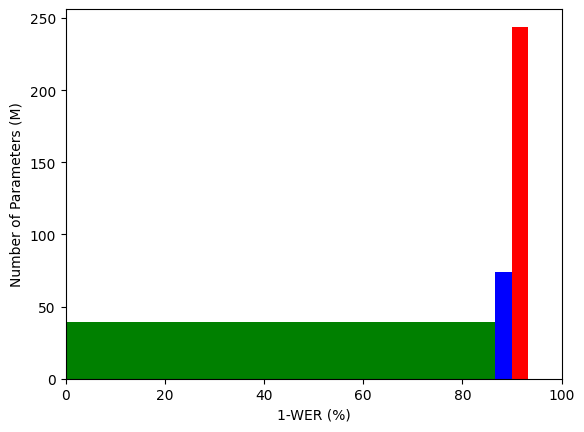

In [31]:
import matplotlib.pyplot as plt
paras = [39, 74, 244]
wer = [13.52, 10.02, 6.74]
wer = [100 - w for w in wer]
width = np.diff([0] + wer)
mid = wer - width / 2

plt.bar(mid, paras, width, color=['green', 'blue', 'red'])
# plt.plot(paras, wer)
plt.xlim(0, 100)
plt.xlabel("1-WER (%)")
plt.ylabel("Number of Parameters (M)")
plt.show()